# **Gene Expression Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*DGE.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialGeneExpressionAnalysis.ipynb` notebook.

In [1]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(stringr)
library(edgeR)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

options(warn = defaultW)

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




## 2. Making the matrices

### 2.1 Read in all the differential Gene Expression Analysis results

In [2]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
message("Number of DGE files found with *_DGE.csv pattern: ",length(filenames))

Number of DGE files found with *_DGE.csv pattern: 39



### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
head(filenames)
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))

[1] "../data/adipose_subcutaneous_DGE.csv"    
[2] "../data/adipose_visceral_omentum_DGE.csv"
[3] "../data/adrenal_gland_DGE.csv"           
[4] "../data/artery_aorta_DGE.csv"            
[5] "../data/artery_coronary_DGE.csv"         
[6] "../data/artery_tibial_DGE.csv"


 0  1 
11 39 

Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)39 5



### 2.3 model rownames from first file for the matrices

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [4]:
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [5]:
head(logFC_mat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,0.16684237,5.597666,4.0610756,5.465700e-05,9.376647e-04,-0.2707622
ENSG00000000005.5,0.23130821,4.045079,2.5394838,1.132847e-02,5.745540e-02,-5.0054833
ENSG00000000419.12,-0.01502264,4.689382,-0.7406893,4.591428e-01,6.463227e-01,-8.0189174
ENSG00000000457.13,0.01135089,3.928636,0.5522265,5.809783e-01,7.426003e-01,-8.0387087
ENSG00000000460.16,-0.03523189,2.247331,-1.1859008,2.360842e-01,4.312669e-01,-7.2481101
ENSG00000000938.12,0.37491369,5.222112,5.2569476,1.976409e-07,9.547977e-06,5.1683942


### 2.4 function make_tissue_matrix_ready for the logFC values

This function makes a logFC matrix for each of the tissues from the **`tissue_DGE.tsv`** results. One for each of our **`tissues`** of interest.

In [6]:
make_tissue_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}


### 2.5 function make_pval_matrix_ready for the adjusted P values

This function makes an adjPVal matrix for each of the tissues from the **`tissue_DGE.tsv`** results.  One for each of our **`tissues`** of interest.

In [7]:
make_pval_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    pVal_mat       <- read.csv(filename)
    pVal_mat       <- pVal_mat[order(rownames(pVal_mat)),]
    pVal           <- as.matrix(as.numeric(pVal_mat$adj.P.Val),ncol=1)
    rownames(pVal) <- rownames(pVal_mat)
    return(pVal)
}

### 2.6 Use lapply and call make_tissue_matrix_ready

With all of the files, prepare a logFC matrix.

In [8]:
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready)
message("Length of matrix_list", length(matrix_list))

Length of matrix_list39



### 2.7 Use lapply and call make_pval_matrix_ready

With all of the files, prepare the pVal matrix.

In [9]:
pVal_matrix_list <- lapply(X=filenames, FUN=make_pval_matrix_ready)
message("Length of pVal_matrix_list: ", length(pVal_matrix_list))

Length of pVal_matrix_list: 39



In [10]:
# rows are the number of samples, columns are the tissues
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                             nrow = nrow(logFC_mat), 
                             ncol = length(matrix_list))
message("Length of logFC_mat (corresponds to number of tissues from DGE files): ", length(logFC_mat))

Length of logFC_mat (corresponds to number of tissues from DGE files): 39



In [11]:
# rows are the number of samples, columns are the tissues
pVal_mat = as.matrix(lapply(X    = pVal_matrix_list, 
                            FUN  = cbind),
                            nrow = nrow(logFC_mat), 
                            ncol = length(pVal_matrix_list))
message("Length of pVal_mat (corresponds to number of tissues from DGE files): ", length(pVal_mat))

Length of pVal_mat (corresponds to number of tissues from DGE files): 39



In [12]:
tissue_list  <- levels(factor(tissue_reduction$SMTSD))
message("Number of tissues with at least 50 samples for both sexes: ",length(tissue_list))

Number of tissues with at least 50 samples for both sexes: 39



In [13]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=length(tissue_list), ncol=1))
dim(logFC_mat)
head(logFC_mat)
for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=length(tissue_list), ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            logFC_mat_rownames)
head(display_name)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)


[1] 42271     1

0.16684237
0.23130821
-0.01502264
0.01135089
-0.03523189
0.37491369


[1] 42271    39

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.16684237,-0.053128301,0.0005662481,0.02311947,0.0515948103,0.015698422,0.02000993,0.1741436559,0.08835179,0.130148155,⋯,-0.001478042,0.06579017,-0.30040532,-0.058210282,0.07209523,0.14826920,-0.014671899,0.046478381,-0.08665262,0.123033821
ENSG00000000005.5,0.23130821,-0.499045010,-0.4877345072,0.40177040,0.1274711523,0.115836456,-0.21043520,0.0365238179,-0.15438220,0.067856193,⋯,-0.474743418,0.28827876,-0.07960958,-0.348480087,0.37890414,0.07444427,0.156636787,0.291778254,0.17431582,-0.162450684
ENSG00000000419.12,-0.01502264,0.058319674,0.0300749191,0.01417460,0.0375848607,0.008218077,0.07282219,-0.0001632355,0.03363599,0.023336007,⋯,-0.002268327,-0.02226997,-0.05584116,0.005053431,0.05570708,-0.01223538,0.004228302,-0.053954666,-0.01505403,0.138025150
ENSG00000000457.13,0.01135089,0.007000443,-0.0435162023,0.02958527,0.0043529325,0.071576053,0.03518789,0.0241551235,0.01908890,-0.030572603,⋯,-0.015736799,-0.01218343,0.04089162,-0.036543337,-0.06818343,0.01846910,0.030461568,-0.007703019,0.02000447,0.180915846
ENSG00000000460.16,-0.03523189,0.020835544,0.0171790516,0.04770330,-0.0300118426,0.036949424,-0.01812014,0.0242093186,0.01584736,-0.001087816,⋯,-0.013961552,0.01653652,0.05706269,0.011567953,-0.04649465,0.05301652,0.072206989,-0.017987619,0.05085449,0.006080955
ENSG00000000938.12,0.37491369,0.131821369,-0.1738630446,0.11211843,0.0007242278,0.024212565,0.33135334,0.3912771965,0.16814608,0.327383541,⋯,0.176767040,-0.30544730,0.03283743,0.253781813,0.33226437,-0.01178764,-0.124062870,0.025898584,0.15324707,0.050002805


In [14]:
pVal_mat = as.matrix(as.numeric(unlist(pVal_matrix_list[1]),nrow=length(tissue_list), ncol=1))
dim(pVal_mat)
head(pVal_mat)
for (i in (2:length(pVal_matrix_list))) {
    n = as.matrix(as.numeric(unlist(pVal_matrix_list[i]),nrow=length(tissue_list), ncol=1))
    pVal_mat = cbind(pVal_mat, n)
}

dim(pVal_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            pVal_mat_rownames)
head(display_name)
rownames(pVal_mat) = pVal_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)

[1] 42271     1

9.376647e-04
5.745540e-02
6.463227e-01
7.426003e-01
4.312669e-01
9.547977e-06


[1] 42271    39

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.16684237,-0.053128301,0.0005662481,0.02311947,0.0515948103,0.015698422,0.02000993,0.1741436559,0.08835179,0.130148155,⋯,-0.001478042,0.06579017,-0.30040532,-0.058210282,0.07209523,0.14826920,-0.014671899,0.046478381,-0.08665262,0.123033821
ENSG00000000005.5,0.23130821,-0.499045010,-0.4877345072,0.40177040,0.1274711523,0.115836456,-0.21043520,0.0365238179,-0.15438220,0.067856193,⋯,-0.474743418,0.28827876,-0.07960958,-0.348480087,0.37890414,0.07444427,0.156636787,0.291778254,0.17431582,-0.162450684
ENSG00000000419.12,-0.01502264,0.058319674,0.0300749191,0.01417460,0.0375848607,0.008218077,0.07282219,-0.0001632355,0.03363599,0.023336007,⋯,-0.002268327,-0.02226997,-0.05584116,0.005053431,0.05570708,-0.01223538,0.004228302,-0.053954666,-0.01505403,0.138025150
ENSG00000000457.13,0.01135089,0.007000443,-0.0435162023,0.02958527,0.0043529325,0.071576053,0.03518789,0.0241551235,0.01908890,-0.030572603,⋯,-0.015736799,-0.01218343,0.04089162,-0.036543337,-0.06818343,0.01846910,0.030461568,-0.007703019,0.02000447,0.180915846
ENSG00000000460.16,-0.03523189,0.020835544,0.0171790516,0.04770330,-0.0300118426,0.036949424,-0.01812014,0.0242093186,0.01584736,-0.001087816,⋯,-0.013961552,0.01653652,0.05706269,0.011567953,-0.04649465,0.05301652,0.072206989,-0.017987619,0.05085449,0.006080955
ENSG00000000938.12,0.37491369,0.131821369,-0.1738630446,0.11211843,0.0007242278,0.024212565,0.33135334,0.3912771965,0.16814608,0.327383541,⋯,0.176767040,-0.30544730,0.03283743,0.253781813,0.33226437,-0.01178764,-0.124062870,0.025898584,0.15324707,0.050002805


### 2.8 Reduce the matrix to only those that pass FC > 1.5 and <= adjusted pVal < 0.05

Remove the cells in the matrix that are <= abs(log2(1.5)) preserving only the values that are FC >= 1.5 and adj.P.Val <= 0.05 (from a separate but coordinated matrix.

In [15]:
logFC_ct <- rowSums(abs(logFC_mat) >= log2(1.5))
pVal_ct  <- rowSums(pVal_mat <= 0.05)

logFC_pass <- logFC_ct>1
table(logFC_pass)
pVal_pass  <-  pVal_ct>1
table(pVal_pass)

logFC_pVal_pass <- logFC_ct & pVal_ct
table(logFC_pVal_pass)

id <- logFC_pVal_pass

logFC_gt_1.5 <- logFC_mat[id,]

dim(logFC_gt_1.5)
head(logFC_gt_1.5)

logFC_pass
FALSE  TRUE 
38911  3360 

pVal_pass
FALSE  TRUE 
18699 23572 

logFC_pVal_pass
FALSE  TRUE 
33400  8871 

[1] 8871   39

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000005.5,0.23130821,-0.4990450,-0.4877345,0.40177040,0.1274711523,0.11583646,-0.21043520,0.03652382,-0.15438220,0.06785619,⋯,-0.4747434,0.2882788,-0.07960958,-0.3484801,0.378904141,0.07444427,0.15663679,0.29177825,0.17431582,-0.16245068
ENSG00000000938.12,0.37491369,0.1318214,-0.1738630,0.11211843,0.0007242278,0.02421257,0.33135334,0.39127720,0.16814608,0.32738354,⋯,0.1767670,-0.3054473,0.03283743,0.2537818,0.332264371,-0.01178764,-0.12406287,0.02589858,0.15324707,0.05000281
ENSG00000001626.14,-0.33434346,-0.5227592,0.0773477,0.25173710,0.2239262218,-0.11913446,-0.13793425,0.30327916,0.06420902,-0.21390011,⋯,0.1019172,-0.1437217,-0.28030422,-0.2738003,-0.118647613,0.46988876,0.02774882,0.15196853,0.17683067,-0.14098185
ENSG00000002586.18,-0.28982029,-0.3266196,-0.7504299,-0.29292103,-0.4142025368,-0.46102666,-0.74695957,-0.59304127,-0.59027507,-0.68628112,⋯,-0.4932675,-0.2700708,-0.90801715,-0.3180398,-0.156001963,-0.43644328,-0.46854424,-0.49403973,-0.44263777,-0.37231473
ENSG00000002726.20,0.12537791,-0.2112274,0.1301867,0.11796210,-0.2171313772,-0.15191953,-0.04528011,-0.09429611,-0.14036404,0.33280905,⋯,0.2315042,-0.4494418,-0.29017572,-0.2869428,-0.182243975,0.75197182,0.34552648,0.41312232,0.04861501,0.08363956
ENSG00000002746.14,-0.04483356,0.3794256,-0.1027417,0.06056207,-0.1809939396,-0.13629235,-0.09839488,-0.01914131,-0.04899283,-0.11081531,⋯,-0.1563662,0.1459822,-0.25600139,-0.1747277,0.002727431,-0.10601395,-0.37792598,0.02437217,-0.25340606,-0.11057413


### 2.9 Calculate the correlation between the tissues using the logFC

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

In [16]:
# dist_mat all values logFC_mat
dist_mat <- as.matrix(cor(logFC_mat))

## 3. Render the heatmaps of the distance correlations

### 3.1 heatmap logFC

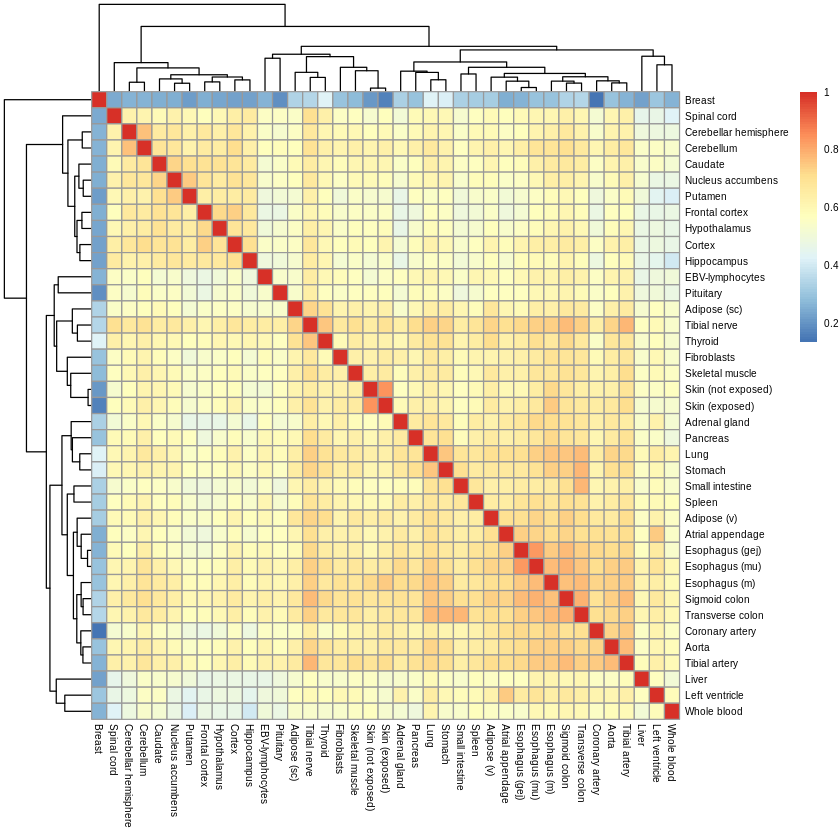

In [17]:
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC.pdf"))

### 3.2 heatmap normalize quantiles logFC_mat

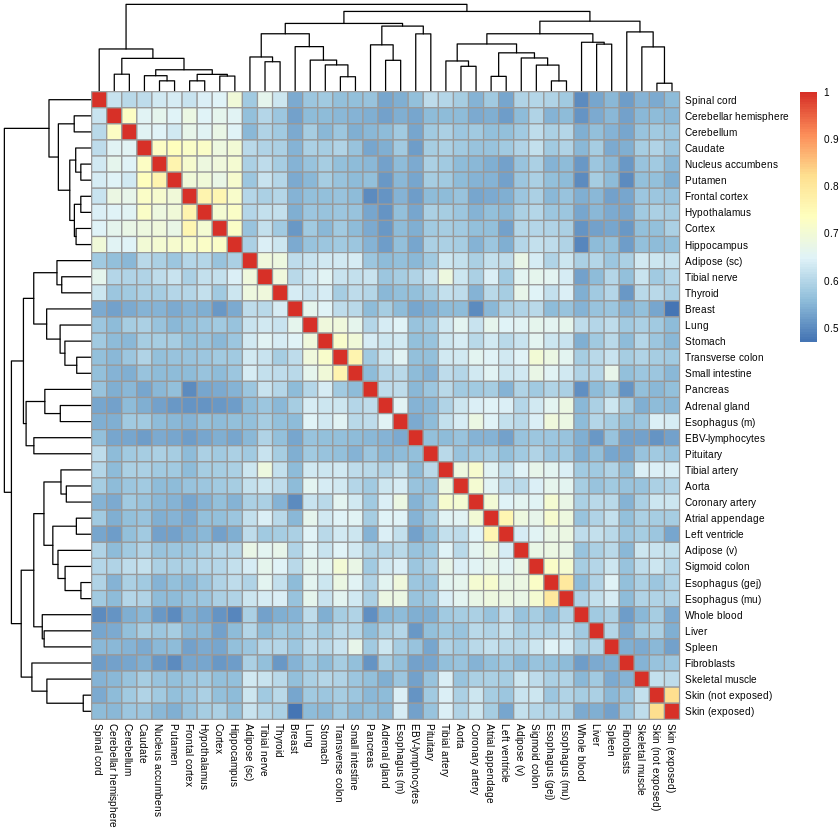

In [18]:
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)
dist_mat <- as.matrix(cor(logFC_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationAlllogFC_NQ.pdf"))

### 3.3 heatmap logFC >= 1.5 and adjusted p Value < 0.05

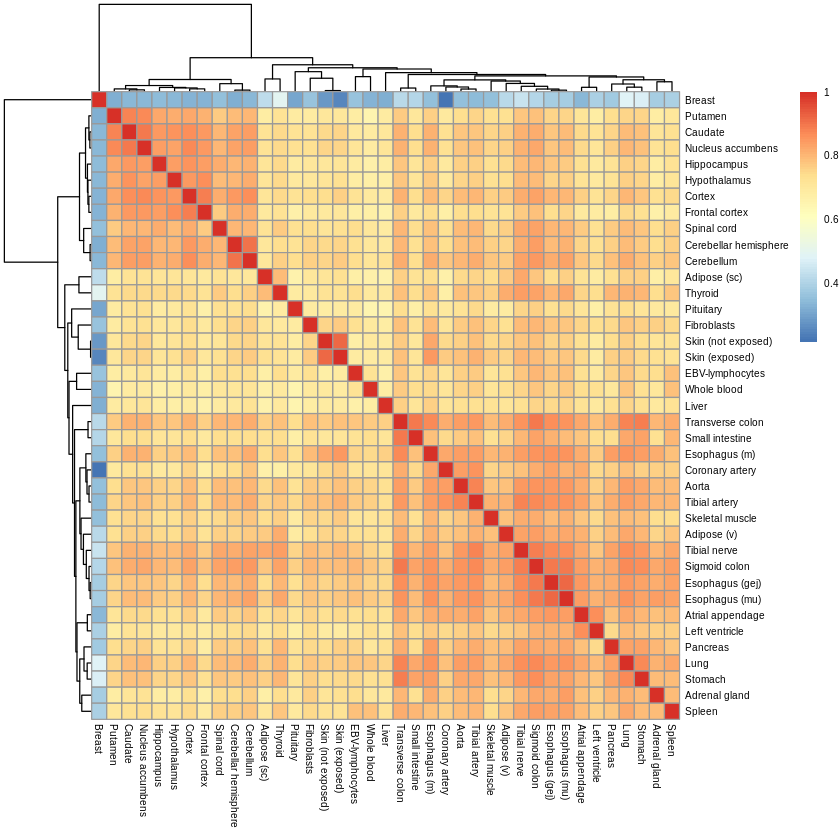

In [20]:
# dist_mat all values with logFC_mat_gt_1.5 
dist_mat <- as.matrix(cor(logFC_gt_1.5))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC_gt_1.5.pdf"))

### 3.4 heatmap normalize quantiles logFC >= 1.5 and adjusted pValue < 0.05

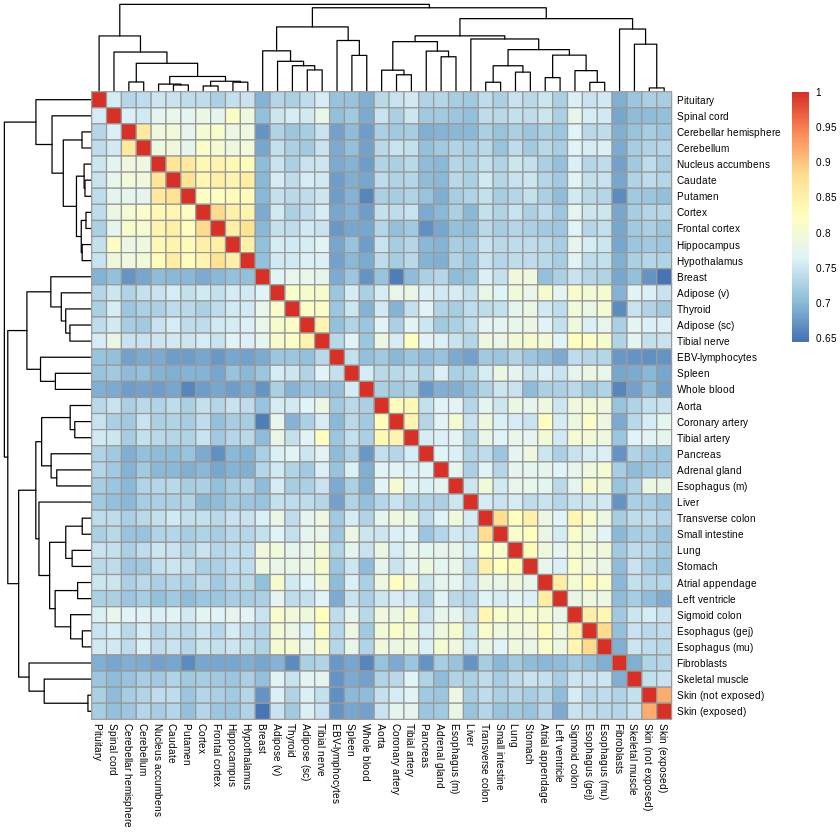

In [21]:
# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat_gt_1.5_NQ <- normalizeQuantiles(logFC_gt_1.5)
dist_mat <- as.matrix(cor(logFC_mat_gt_1.5_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC_gt_1.5NQ.pdf"))


### 3.5 save the logFC_mat_gt_1.5_NQ rds object

In [22]:
rownames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)
colnames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object

Done!



## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [23]:
figure_id   = "expressionHeatmap"

### Appendix.2. Libraries

In [24]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-06-22                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.0,3.28.0,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
magrittr,magrittr,1.5,1.5,/opt/conda/lib/R/library/magrittr,/opt/conda/lib/R/library/magrittr,TRUE,FALSE,2014-11-22,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/lib/R/library/pheatmap,/opt/conda/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
scales,scales,1.1.0,1.1.0,/opt/conda/lib/R/library/scales,/opt/conda/lib/R/library/scales,TRUE,FALSE,2019-11-18,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
stringr,stringr,1.4.0,1.4.0,/opt/conda/lib/R/library/stringr,/opt/conda/lib/R/library/stringr,TRUE,FALSE,2019-02-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
viridis,viridis,0.5.1,0.5.1,/opt/conda/lib/R/library/viridis,/opt/conda/lib/R/library/viridis,TRUE,FALSE,2018-03-29,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
